In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [19]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [20]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [21]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.26974167)>
51400.0 pc


In [22]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [23]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 35.08791072 yr>

In [24]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

17.543955361878034 lyr


In [25]:
# A few things to compute for each GCNS object:

# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

In [26]:
print(len(d1))
print(sum(SNYES), sum(SNNO), sum(EYES), sum(OYES))
print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
192355 138957 25702 139
0.5805856715120491
0.41941432848795096
0.07757642343168977


Text(0, 0.5, 'Z (pc)')

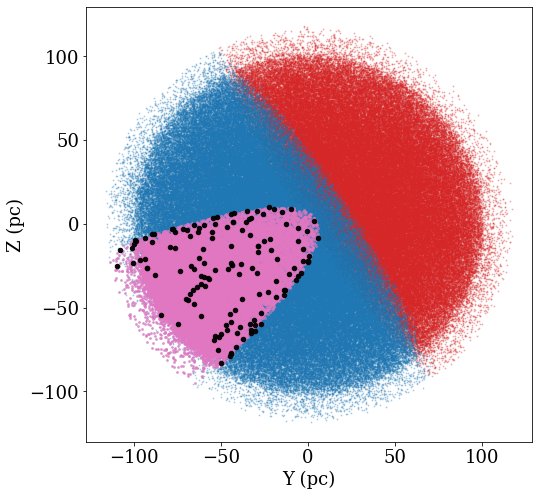

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
# plt.grid(True)
# plt.savefig('GCNS_SN1987A_on.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [28]:
# so the Ellipsoid is defined as:
# d2 + r = 2c + time
#  so .... time = d2 + r - 2c
etime = d2.to('lyr') + d1.to('lyr') - (2*c)


x10 = np.abs(GCNS['XCOORD_50']) < 10

In [29]:
sum(x10)

47484

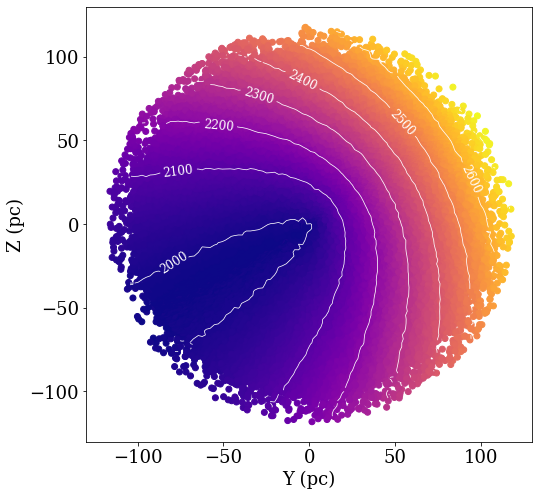

In [30]:
H, xe, ye, bn = binned_statistic_2d(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10], 
                                    values = etime[x10].value + t0.decimalyear, statistic='mean', bins=100)
XX, YY = np.meshgrid(xe, ye)

plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10], 
            c=(etime[x10].value + t0.decimalyear), cmap=plt.cm.plasma, rasterized=True)
# cb = plt.colorbar()
# cb.set_label('$t - $'+format(t0.decimalyear, '7.4f') + ' (years)')

cs = plt.contour(xe[1:], ye[1:], H.T, colors='w', linewidths=0.75)
plt.clabel(cs,fontsize=12)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.xlim(-130,130)
plt.ylim(-130,130)
plt.savefig('GCNS_SN1987A_years.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

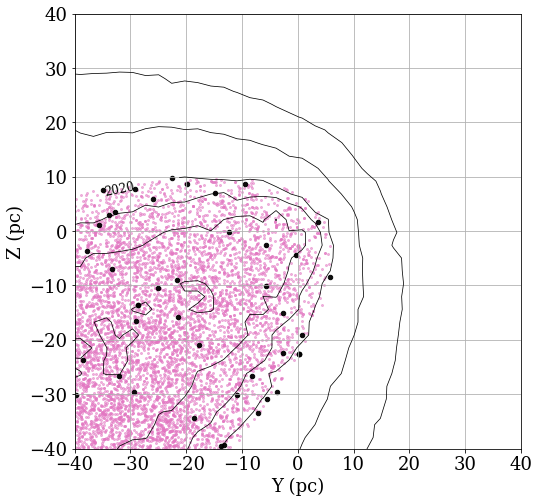

In [31]:
plt.figure(figsize=(8,8))
# plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=0.75, levels=[1990,2000,2010,2020,2050, 2087])
plt.clabel(cs,fontsize=12)

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.grid(True)
# plt.savefig('GCNS_SN1987A_on.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0, 0.5, 'Z (pc)')

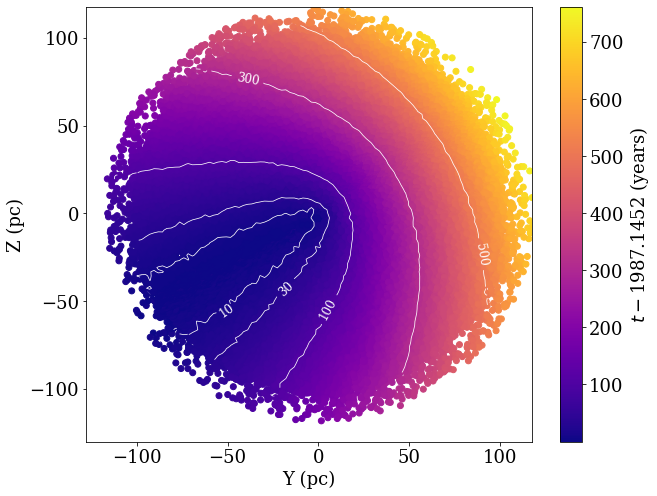

In [32]:
H, xe, ye, bn = binned_statistic_2d(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10], 
                                    values = etime[x10].value , statistic='mean', bins=100)
XX, YY = np.meshgrid(xe, ye)

plt.figure(figsize=(10,8))
plt.scatter(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10], 
            c=(etime[x10].value ), cmap=plt.cm.plasma)
cb = plt.colorbar()
cb.set_label('$t - $'+format(t0.decimalyear, '7.4f') + ' (years)')

cs = plt.contour(xe[1:], ye[1:], H.T, colors='w', linewidths=0.75, levels = [10,30,100,300,500])
plt.clabel(cs,fontsize=12)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')


In [33]:
hh, be = np.histogram(etime.value, bins = np.arange(100))
# on average, how many stars PER YEAR cross the ellipsoid (etime)
print(np.mean(hh), np.median(hh))

734.5555555555555 737.0


In [34]:
derror = (((GCNS['DIST_84']-GCNS['DIST_50']) + (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value
op = (derror < 0.1)

hh1, be1 = np.histogram(etime[op].value, bins = np.arange(100))
# on average, how many stars PER YEAR cross the ellipsoid (etime) w/ distance errors < 0.1 lyr
print(np.mean(hh1), np.median(hh1))

79.0 79.0


In [35]:
sum(derror < 1) / len(GCNS)

0.5429595064470952

In [36]:
sum(derror < .1) / len(GCNS)

0.041619379919833874

In [37]:
sum(derror < .1)

13789

12.3068165 15.149171


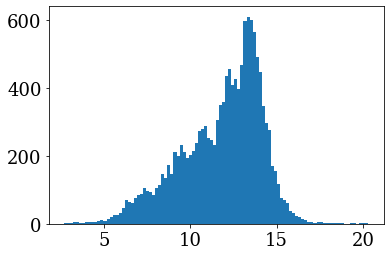

In [40]:
print(np.nanmedian(GCNS['PHOT_G_MEAN_MAG'][derror < 0.1]), np.nanmedian(GCNS['PHOT_G_MEAN_MAG']))
_ = plt.hist(GCNS['PHOT_G_MEAN_MAG'][derror < 0.1], bins=100)

Text(0, 0.5, 'Number of Stars')

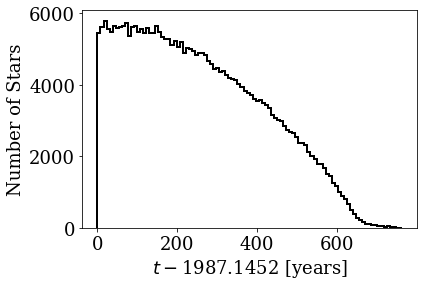

In [60]:
_ = plt.hist(etime.value,bins=100, histtype='step', density=False, lw=2, color='k')
plt.xlabel('$t - $'+format(t0.decimalyear, '7.4f') + ' [years]')
plt.ylabel('Number of Stars')
# plt.xlim(0,100)

In [115]:
len(GCNS) / (np.pi * ((100 * u.pc).to('lyr'))**3)

<Quantity 0.00303955 1 / lyr3>

In [240]:
from scipy.stats import mode

def mmode(x):
    return mode(x)[0][0]

def mmax(x):
    hh, be = np.histogram(x, bins=100)
    
    return ((be[1:]+be[0:-1])/2)[np.argmax(hh)]

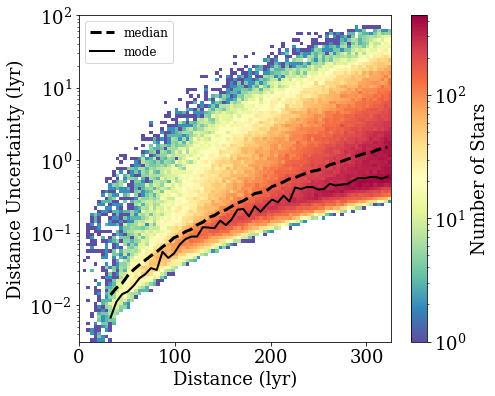

In [275]:
plt.figure(figsize=(7,6))
_ = plt.hist2d((GCNS['DIST_50']*u.kpc).to('lyr').value, 
            (((GCNS['DIST_84']-GCNS['DIST_50']) + (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value,
                bins=[np.linspace(0,380,100), np.logspace(-2.5,2,100)], 
               cmap=plt.cm.Spectral_r, norm=LogNorm())

cb = plt.colorbar()
cb.set_label('Number of Stars')

# bin_means, bin_edges, binnumber
H1,xe,bn = binned_statistic((GCNS['DIST_50']*u.kpc).to('lyr').value, 
            values=((((GCNS['DIST_84']-GCNS['DIST_50']) + 
                              (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value), 
                           statistic='median', bins=np.linspace(30,325,50))

plt.plot((xe[1:]+xe[0:-1])/2., H1, c='k', lw=3, ls='--', label='median')

H2,xe,bn = binned_statistic((GCNS['DIST_50']*u.kpc).to('lyr').value, 
            values=((((GCNS['DIST_84']-GCNS['DIST_50']) + 
                              (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value), 
                           statistic=mmax, bins=np.linspace(30,325,50))

plt.plot((xe[1:]+xe[0:-1])/2., H2, c='k', lw=2, label='mode')


plt.xlabel('Distance (lyr)')
plt.ylabel('Distance Uncertainty (lyr)')
plt.yscale('log')
plt.legend(fontsize=12, loc='upper left')

plt.xlim(0, (100 * u.pc).to('lyr').value)
plt.savefig('GCNS_Derrors.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

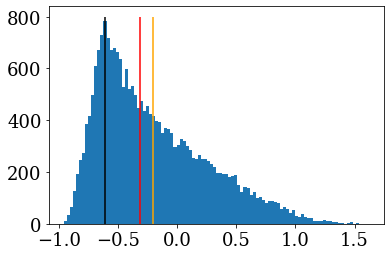

In [249]:
xr = ((GCNS['DIST_50']*u.kpc).to('lyr').value > 200) & ((GCNS['DIST_50']*u.kpc).to('lyr').value < 220)
_ = plt.hist(np.log10(((((GCNS['DIST_84']-GCNS['DIST_50']) + 
                              (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value)[xr]), bins=100)
plt.vlines(np.median(np.log10(((((GCNS['DIST_84']-GCNS['DIST_50']) + 
                              (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value)[xr])), 
           0, 800, color='r')

plt.vlines(np.mean(np.log10(((((GCNS['DIST_84']-GCNS['DIST_50']) + 
                              (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value)[xr])), 
           0, 800, color='orange')

plt.vlines(mmax(np.log10(((((GCNS['DIST_84']-GCNS['DIST_50']) + 
                              (GCNS['DIST_50']-GCNS['DIST_16']))/2. * u.kpc).to('lyr').value)[xr])), 
           0, 800, color='k')



In [257]:
((xe[1:]+xe[0:-1])/2.)[H1 < 0.1]

array([ 33.01020408,  39.03061224,  45.05102041,  51.07142857,
        57.09183673,  63.1122449 ,  69.13265306,  75.15306122,
        81.17346939,  87.19387755,  93.21428571,  99.23469388,
       105.25510204])

In [256]:
((xe[1:]+xe[0:-1])/2.)[H2 < 0.1]

array([ 33.01020408,  39.03061224,  45.05102041,  51.07142857,
        57.09183673,  63.1122449 ,  69.13265306,  75.15306122,
        81.17346939,  87.19387755,  93.21428571,  99.23469388,
       105.25510204, 111.2755102 , 117.29591837, 123.31632653])

In [292]:
# are any of the objects on the surface in the Alert database?
#   match to the gaia alerts databse
al = Table.read('Gaia_alerts.csv')
print(len(al))

19355


In [293]:
Cal = SkyCoord(ra=al['RaDeg']*u.deg, dec=al['DecDeg']*u.deg)

COYES = SkyCoord(ra=GCNS['RA'][OYES]*u.deg, dec=GCNS['DEC'][OYES]*u.deg)

idx, d2d, d3d = COYES.match_to_catalog_sky(Cal)

# what is the separation for the closest alert?
print(d2d.arcsec.min())

208.25067631946249


In [312]:
# what about stars that have crossed the ellipsoid in the past ~7yrs

# the first alert
AL1 = (Time(al['Date'], format='iso')-t0).to('year').value.min()

# etime
e7 = ((etime.value >= AL1) & # since the first alert
      (etime.value < ((t1-t0).to('year').value+0.1)) # up to 0.1 years from now
     ) 
print(sum(e7))

CE7 = SkyCoord(ra=GCNS['RA'][e7]*u.deg, dec=GCNS['DEC'][e7]*u.deg)

idx, d2d, d3d = CE7.match_to_catalog_sky(Cal)

# what is the separation for the closest alert?
print(d2d.arcsec.min())

5658
63.98308264296608


In [319]:
Time(al['Date'], format='iso').decimalyear.min()

2014.569312182902